In [1]:
import pandas as pd    
import geopandas as gpd
import datetime
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

### Importing Zip Codes

In [2]:
# Loads zip code boundary data
zipcodes_url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
z = gpd.read_file(zipcodes_url)

In [3]:
z.head()

,OBJECTID,ZIP,ZIPCODE,COUNTY,SHAPE_Length,SHAPE_Area,geometry
0,1,98031,98031,033,117508.211718,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,2,98032,98032,033,166737.664791,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,3,98033,98033,033,101363.840369,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20571 47.6..."
3,4,98034,98034,033,98550.452509,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17551 47.7..."
4,5,98030,98030,033,94351.264837,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


In [3]:
# Creates a dataframe "zips" of zip codes, areas, and geometries
#zip_cols = ['ZIPCODE', 'SHAPE_Area', 'geometry']
#zips = z.loc[:,zip_cols]
#zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)

#new_cols = ['Zipcode', 'Area (ft^2)?']
#rename_dict = {}
#for i in range(len(zip_cols)-1):
    #rename_dict[zip_cols[i]] = new_cols[i]
#zips.rename(columns=rename_dict, inplace=True)
#zips.sort_values(by='Zipcode', inplace=True)
#zips.set_index(np.arange(0,len(zips),1), inplace=True)
#zips.index.name = 'ID'

- Now we need to join the zips geodataframe to the census tracts using the sjoin function in geopandas

In [4]:
# Loads census tract boundary data
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
t = gpd.read_file(census_url)

In [7]:
# Creates a dataframe "tracts" of tract number, areas, and geometries
#tract_cols = ['NAME10', 'SHAPE_Area', 'geometry']
#tracts = t.loc[:,tract_cols]
#tracts['NAME10'] = tracts['NAME10'].astype(float)
#new_cols = ['Tract', 'Area (ft^2)?', 'geometry']
#rename_dict = {}
#for i in range(len(tract_cols)):
    #rename_dict[tract_cols[i]] = new_cols[i]
#tracts.rename(columns=rename_dict, inplace=True)
#tracts.sort_values(by='Tract', inplace=True)
#tracts.set_index(np.arange(0,len(tracts),1), inplace=True)
#tracts.index.name = 'ID'

In [8]:
#len(tracts) #Check output against the number of census tracts, should be 135 if we picked the correct function works

135

- Now Filter out the census tracts which are outliers when we normalize by area 

In [9]:
# Filters out tracts with irregular traffic data
#filter1 = tracts.Tract == 260.01
#filter2 = tracts.Tract == 264.0
#indices1 = tracts[filter1].index
#indices2 = tracts[filter2].index
#tracts.drop(indices1, inplace=True)
#tracts.drop(indices2, inplace=True)

In [10]:
#len(tracts) #Double check the two subtracted tracts

133

- Now we want to join our two metric census tracts and zipcodes.  

In [5]:
# Joins zip codes with census tracts
ziptracts = gpd.sjoin(z, t, op='intersects')
ziptracts.head()

,OBJECTID_left,ZIP,ZIPCODE,COUNTY,SHAPE_Length_left,SHAPE_Area_left,geometry,index_right,OBJECTID_right,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area_right
34,35,98101,98101,033,23619.028932,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",73,117,7402,007402,53033007402,74.02,Census Tract 74.02,61.596617,0,7060.263667,2.683149e+06
35,36,98102,98102,033,37488.788166,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6...",73,117,7402,007402,53033007402,74.02,Census Tract 74.02,61.596617,0,7060.263667,2.683149e+06
77,78,98122,98122,033,49484.404281,6.454818e+07,"POLYGON ((-122.32272 47.61931, -122.32282 47.6...",73,117,7402,007402,53033007402,74.02,Census Tract 74.02,61.596617,0,7060.263667,2.683149e+06
34,35,98101,98101,033,23619.028932,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6...",75,119,7401,007401,53033007401,74.01,Census Tract 74.01,64.092745,0,8333.348665,2.791880e+06
35,36,98102,98102,033,37488.788166,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6...",75,119,7401,007401,53033007401,74.01,Census Tract 74.01,64.092745,0,8333.348665,2.791880e+06


In [12]:
# Defines x and y boundaries of area covered by tracts
#minx = min(tracts.geometry.bounds.minx)
#maxx = max(tracts.geometry.bounds.maxx)
#miny = min(tracts.geometry.bounds.miny)
#maxy = max(tracts.geometry.bounds.maxy)

# Shrinks the area covered by ziptracts to the area covered by tracts
#minx_filter = minx < ziptracts.geometry.bounds.minx
#maxx_filter = maxx > ziptracts.geometry.bounds.maxx
#miny_filter = miny < ziptracts.geometry.bounds.miny
#maxy_filter = maxy > ziptracts.geometry.bounds.maxy

#ziptracts = ziptracts[minx_filter & maxx_filter & miny_filter & maxy_filter]

<AxesSubplot:>

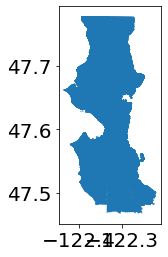

In [6]:
ziptracts.plot()

In [8]:
len(ziptracts['ZIPCODE'])

288

In [9]:
zips = ziptracts.dissolve(by='ZIPCODE')

In [10]:
len(zips)

32

In [23]:
zips.reset_index(inplace=True)

In [24]:
zips.head()

,ZIPCODE,geometry,OBJECTID_left,ZIP,COUNTY,SHAPE_Length_left,SHAPE_Area_left,index_right,OBJECTID_right,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area_right
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",35,98101,033,23619.028932,1.470012e+07,73,117,7402,007402,53033007402,74.02,Census Tract 74.02,61.596617,0,7060.263667,2.683149e+06
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",36,98102,033,37488.788166,4.322189e+07,73,117,7402,007402,53033007402,74.02,Census Tract 74.02,61.596617,0,7060.263667,2.683149e+06
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",68,98103,033,71421.204751,1.440083e+08,51,92,4500,004500,53033004500,45,Census Tract 45,165.797510,0,11018.301533,7.222140e+06
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",69,98104,033,35668.302517,2.108730e+07,68,112,8400,008400,53033008400,84,Census Tract 84,94.542483,0,10061.807183,4.118271e+06
4,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",70,98105,033,77620.084289,9.703543e+07,41,82,4100,004100,53033004100,41,Census Tract 41,787.830676,0,35293.161989,3.431790e+07


In [25]:
zips = zips[['geometry', 'ZIPCODE', 'ACRES_TOTAL']]

In [26]:
zips.head()

,geometry,ZIPCODE,ACRES_TOTAL
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617
1,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",98102,61.596617
2,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",98103,165.797510
3,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",98104,94.542483
4,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",98105,787.830676


- Need to load bike lane and walkway data

In [27]:
#Bike lanes and walkways
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

In [28]:
df_SND.columns

Index(['OBJECTID', 'F_INTR_ID', 'T_INTR_ID', 'SND_ID', 'SND_FEACOD',
       'CITYCODE', 'STNAME_ID', 'ST_CODE', 'ARTERIAL_C', 'SEGMENT_TY',
       'AGENCY_COD', 'ACCESS_COD', 'DIVIDED_CO', 'STRUCTURE_', 'LEGALLOC_C',
       'VEHICLE_US', 'GIS_SEG_LE', 'L_ADRS_FRO', 'L_ADRS_TO', 'R_ADRS_FRO',
       'R_ADRS_TO', 'ORD_PRE_DI', 'ORD_STREET', 'ORD_STRE_1', 'ORD_SUF_DI',
       'ORD_STNAME', 'L_CITY', 'L_STATE', 'L_ZIP', 'R_CITY', 'R_STATE',
       'R_ZIP', 'SNDSEG_UPD', 'COMPKEY', 'COMPTYPE', 'UNITID', 'UNITID2',
       'SHAPE_Leng', 'geometry'],
      dtype='object')

In [29]:
df_SND.head()

,OBJECTID,F_INTR_ID,T_INTR_ID,SND_ID,SND_FEACOD,CITYCODE,STNAME_ID,ST_CODE,ARTERIAL_C,SEGMENT_TY,...,R_CITY,R_STATE,R_ZIP,SNDSEG_UPD,COMPKEY,COMPTYPE,UNITID,UNITID2,SHAPE_Leng,geometry
0,1,17740,17791,33478,5,1,566,0,1,1,...,SEATTLE,WA,98108,2007-04-22,8460,68,04805,0820,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."
1,2,11391,11295,20097,1,1,659,0,0,1,...,SEATTLE,WA,98102,2007-04-22,9236,68,05465,0010,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47..."
2,3,982,979,42208,1,0,1797,40,0,1,...,LAKE FOREST PARK,WA,98155,2004-05-19,0,0,0,0,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47..."
3,4,11695,11696,20460,77,1,1444,20,0,6,...,SEATTLE,WA,98122,2004-05-19,0,0,0,0,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47..."
4,5,6257,6252,9237,1,1,2086,0,0,1,...,SEATTLE,WA,98107,2012-10-12,18575,68,14630,0200,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47..."


In [30]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike_lane = df_SND[lane_columns]

In [31]:
bike_lane.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry
0,1,2007-04-22,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47..."
1,1,2007-04-22,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47..."
2,1,2004-05-19,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47..."
3,6,2004-05-19,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47..."
4,1,2012-10-12,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47..."


In [32]:
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['SNDSEG_UPD']).year


/home/spristash3/anaconda3/envs/python-gis/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [33]:
bike_lane.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry,Year
0,1,2007-04-22,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,2007-04-22,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,2004-05-19,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,2004-05-19,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,2012-10-12,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012


In [34]:
bike_lane.drop(columns='SNDSEG_UPD')

,SEGMENT_TY,SHAPE_Leng,geometry,Year
0,1,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012
...,...,...,...,...
34201,1,305.488287,"LINESTRING (-122.31417 47.67145, -122.31410 47...",2021
34202,1,97.898257,"LINESTRING (-122.34210 47.60772, -122.34250 47...",2021
34203,1,421.473404,"LINESTRING (-122.32610 47.46873, -122.32440 47...",2021
34204,1,238.008808,"LINESTRING (-122.32440 47.46874, -122.32344 47...",2021


In [42]:
# # Joins zip codes with bike racks
z_bl = gpd.sjoin(zips, bike_lane, op='contains')

In [43]:
z_bl.head()

,geometry,ZIPCODE,ACRES_TOTAL,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617,13878,1,2007-04-22,306.091173,2007
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617,29792,1,2016-06-30,59.805923,2016
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617,29933,1,2016-06-28,310.515656,2016
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617,26277,9,2017-06-09,307.808714,2017
0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",98101,61.596617,18703,1,2017-07-19,307.006498,2017


In [44]:
z_bl= z_bl[z_bl['SEGMENT_TY']==6]

In [45]:
len(z_bl)

305

In [46]:
z_bl.dissolve(by=['Year','ZIPCODE'], aggfunc = 'sum')

geometry  ACRES_TOTAL  \
Year ZIPCODE                                                                   
2004 98101    POLYGON ((-122.34598 47.60892, -122.34490 47.6...   307.983086   
     98102    POLYGON ((-122.33574 47.64203, -122.33108 47.6...   369.579703   
     98103    POLYGON ((-122.35808 47.69966, -122.35741 47.6...   828.987548   
     98105    MULTIPOLYGON (((-122.32859 47.66649, -122.3286...  1575.661352   
     98106    POLYGON ((-122.37057 47.56924, -122.37056 47.5...  1758.574067   
...                                                         ...          ...   
2019 98195    POLYGON ((-122.31218 47.65338, -122.31215 47.6...   627.494719   
2020 98103    POLYGON ((-122.35808 47.69966, -122.35741 47.6...   165.797510   
     98112    MULTIPOLYGON (((-122.31863 47.63049, -122.3186...   283.568433   
     98118    MULTIPOLYGON (((-122.29240 47.53008, -122.2919...   864.560841   
     98136    POLYGON ((-122.40199 47.55763, -122.40137 47.5...   624.108977   

              index_right  SEGMENT_TY   SHAPE_Leng  
Year ZIPCODE                                        
2004 98101          38330          30  1045.937622  
     98102          43677          36  1042.811835  
     98103          60232          30   542.682809  
     98105          11131          12   339.178144  
     98106          72400          36  1445.310174  
...                   ...         ...          ...  
2019 98195          31033           6   107.116326  
2020 98103          34110           6    38.993437  
     98112          33368           6   220.676407  
     98118          34106           6    37.016696  
     98136          33598           6   226.960952  

[105 rows x 5 columns]